#Eye Tracker
It took me ~20min to run the whole on a P100

#####Logging

In [1]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 2.47 ms (started: 2021-05-04 12:41:29 +00:00)


In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-5d96d03c-412a-0cc8-b1a3-d327fafaf651)
time: 119 ms (started: 2021-05-04 12:41:30 +00:00)


##Preprocess data

###Download and decompress the data


In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from PIL import Image
import pathlib

!rm -rf sample_data
filename = 'dataset.zip'
gdd.download_file_from_google_drive(file_id='1U5_KcTyPwIyQ_vPb1kkUlULVnIBLl88N',
                                    dest_path=f'./{filename}')
!unzip -q {filename}
!rm {filename}
with Image.open('dataset/frames/0000001.jpg') as im:
  frameSize = im.size

time: 36.8 s (started: 2021-05-04 12:41:30 +00:00)


### Creating data generator

In [8]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainDataframe = pd.read_csv('dataset/train.csv', delimiter=';')
testDataframe = pd.read_csv('dataset/test.csv', delimiter=';')

trainDatagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.01)
testDatagen = ImageDataGenerator(rescale = 1./255)
batchSize = 1024
print('Training')
trainGenerator = trainDatagen.flow_from_dataframe(
                                              dataframe = trainDataframe,
                                              x_col='image',
                                              y_col=['leftX', 'leftY', 'rightX', 'rightY'],
                                              class_mode = 'raw',
                                              target_size = frameSize,
                                              shuffle = True, 
                                              batch_size=batchSize,
                                              subset = 'training')
print('Validation')
validGenerator = trainDatagen.flow_from_dataframe(
                                              dataframe = trainDataframe,
                                              x_col='image',
                                              y_col=['leftX', 'leftY', 'rightX', 'rightY'],
                                              class_mode = 'raw',
                                              target_size = frameSize,
                                              shuffle = False, 
                                              batch_size=batchSize,
                                              subset = 'validation')
print('Testing')
testGenerator = testDatagen.flow_from_dataframe(
                                              dataframe = testDataframe,
                                              x_col='image',
                                              class_mode = None,
                                              shuffle = False,
                                              target_size = frameSize,
                                              batch_size = 1)

Training
Found 117314 validated image filenames.
Validation
Found 1184 validated image filenames.
Testing
Found 13041 validated image filenames.
time: 1.86 s (started: 2021-05-04 12:52:05 +00:00)


## Creating the model

###Construct

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, AveragePooling2D, Dense, BatchNormalization, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(8, (5,5), input_shape = frameSize + (3,)),
    BatchNormalization(),
    MaxPooling2D(3, 3),
    Conv2D(16, (5,5)),
    BatchNormalization(),
    MaxPooling2D(3,3),
    Conv2D(16, (3,3)),
    BatchNormalization(),
    Conv2D(2, (3,3)),
    BatchNormalization(),
    MaxPooling2D(3,3),
    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dense(4, activation='linear')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 252, 252, 8)       608       
_________________________________________________________________
batch_normalization_4 (Batch (None, 252, 252, 8)       32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 84, 84, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 80, 80, 16)        3216      
_________________________________________________________________
batch_normalization_5 (Batch (None, 80, 80, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 16)       

###Compile

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam',
              loss = 'mse')
es = EarlyStopping(min_delta = 1e-4,
                        patience = 3,
                        verbose = 2,
                        restore_best_weights = True)

time: 16.4 ms (started: 2021-05-04 12:52:13 +00:00)


##Train

In [12]:
epochs = 10
stepsPerEpoch = 100
history = model.fit(trainGenerator,  
                    verbose = 1,
                    validation_data = validGenerator,
                    callbacks = [es],
                    #steps_per_epoch = stepsPerEpoch,
                    epochs = epochs)

Epoch 1/10
115/115 [==============================] - 310s 3s/step - loss: 0.0810 - val_loss: 0.0253
Epoch 2/10
115/115 [==============================] - 278s 2s/step - loss: 0.0188 - val_loss: 0.0139
Epoch 3/10
115/115 [==============================] - 278s 2s/step - loss: 0.0123 - val_loss: 0.0158
Epoch 4/10
115/115 [==============================] - 277s 2s/step - loss: 0.0095 - val_loss: 0.0086
Epoch 5/10
115/115 [==============================] - 279s 2s/step - loss: 0.0074 - val_loss: 0.0058
Epoch 6/10
115/115 [==============================] - 281s 2s/step - loss: 0.0060 - val_loss: 0.0043
Epoch 7/10
115/115 [==============================] - 279s 2s/step - loss: 0.0051 - val_loss: 0.0036
Epoch 8/10
115/115 [==============================] - 277s 2s/step - loss: 0.0046 - val_loss: 0.0035
Epoch 9/10
115/115 [==============================] - 277s 2s/step - loss: 0.0042 - val_loss: 0.0030
Epoch 10/10
115/115 [==============================] - 277s 2s/step - loss: 0.0039 - val_lo

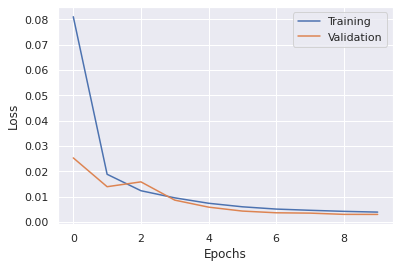

time: 379 ms (started: 2021-05-04 13:40:37 +00:00)


In [15]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

##Evaluate

In [18]:
from sklearn.metrics import mean_squared_error
testGenerator.reset()
prediction = model.predict(testGenerator,
                     steps = len(testDataframe),verbose = 1)
groundTruth = testDataframe[['leftX', 'leftY', 'rightX', 'rightY']].to_numpy()
print(f'test loss: {mean_squared_error(groundTruth,prediction)}')

13041/13041 [==============================] - 60s 5ms/step
test loss: 0.0036352521045470835
time: 1min (started: 2021-05-04 13:45:54 +00:00)


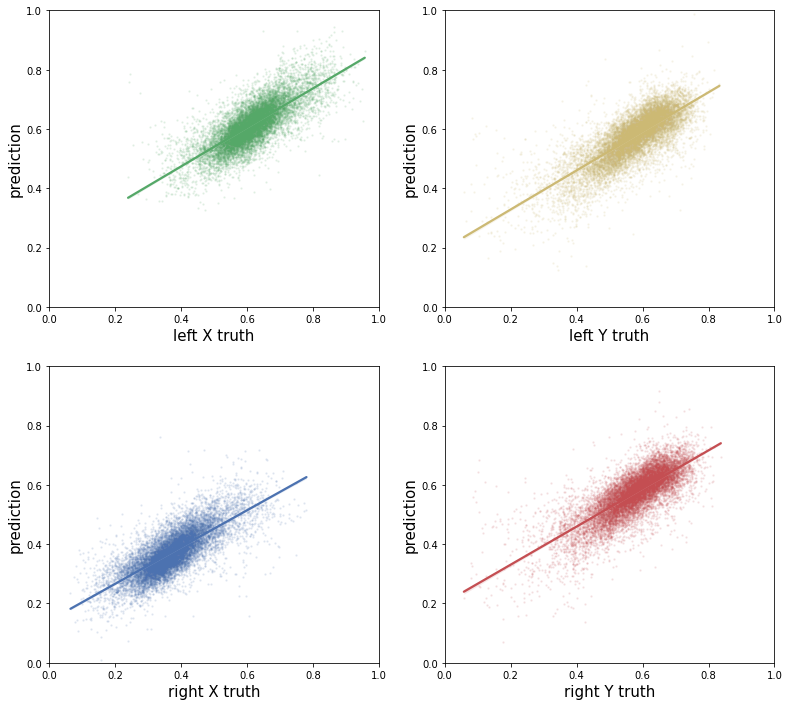

time: 8.08 s (started: 2021-05-04 13:40:26 +00:00)


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 2,
                        ncols = 2,
                        figsize=(13,12))
sns.set_theme(color_codes=True)
plots = []
plots.append(sns.regplot(x = groundTruth[:,0], y = prediction[:,0], ax = axs[0,0], color = 'g', scatter_kws = {'s':2, 'alpha':0.1}))
plots.append(sns.regplot(x = groundTruth[:,1], y = prediction[:,1], ax = axs[0,1], color = 'y', scatter_kws = {'s':2, 'alpha':0.1}))
plots.append(sns.regplot(x = groundTruth[:,2], y = prediction[:,2], ax = axs[1,0], color = 'b', scatter_kws = {'s':2, 'alpha':0.1}))
plots.append(sns.regplot(x = groundTruth[:,3], y = prediction[:,3], ax = axs[1,1], color = 'r', scatter_kws = {'s':2, 'alpha':0.1}))
labels = ['left X truth', 'left Y truth', 'right X truth', 'right Y truth']
for i, plot in enumerate(plots):
  plot.set_xlabel(labels[i], fontsize = 15)
  plot.set_ylabel('prediction', fontsize = 15)
  plot.tick_params(labelsize = 10)
  plot.set(ylim=(0,1),xlim=(0,1))

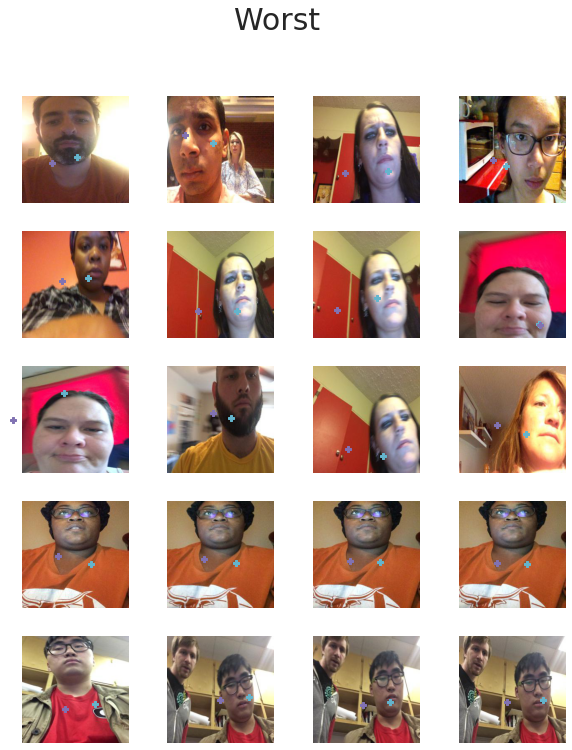

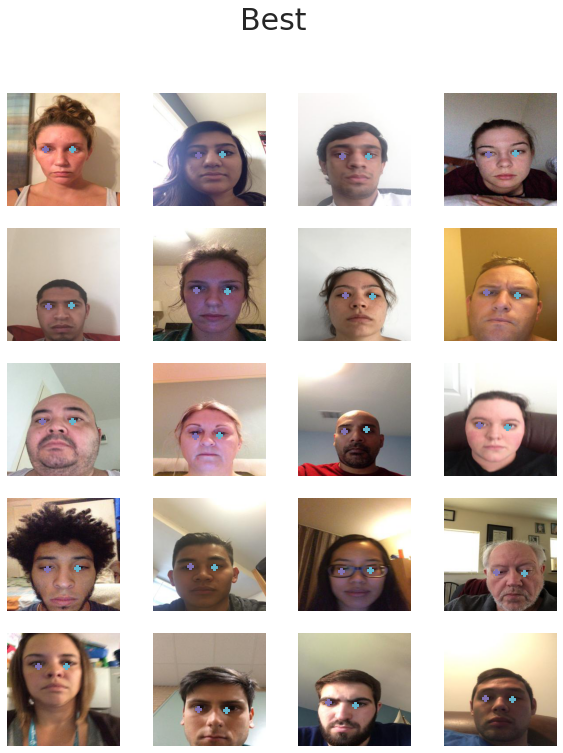

time: 11.5 s (started: 2021-05-04 15:01:04 +00:00)


In [70]:
import numpy as np
mean_squared_error(groundTruth,prediction,multioutput='raw_values')
losses = np.empty((groundTruth.shape[0],2), dtype=np.float32)
for i in range(groundTruth.shape[0]):
  yTruth = groundTruth[i]
  yPred = prediction[i]
  losses[i][0] = mean_squared_error(groundTruth[i],prediction[i])
  losses[i][1] = i

def plotPictures(eyePositions, imagePaths, title):
  fig, axs = plt.subplots(5,4,True,True,figsize=(10,12))
  for i,path in enumerate(paths):
    with Image.open(path) as im:
      axs[i//4][i%4].imshow(im)
      left = eyePositions[i][[0,1]]*im.size
      right = eyePositions[i][[2,3]]*im.size
      axs[i//4][i%4].plot(left[0],left[1],marker='P',color='c')
      axs[i//4][i%4].plot(right[0],right[1],marker='P',color='m')
      axs[i//4][i%4].set_axis_off()
  fig.suptitle(title, fontsize=30)
  plt.show()

losses = losses[losses[:, 0].argsort()] #sort based on first column
worst = losses[-20:] #biggest losses
best = losses[:20] #smallest losses
indexes = np.rint(worst[:,1]).astype(int)  #get the indexes
paths = testDataframe.loc[indexes]['image'].to_numpy()
eyePositions = prediction[indexes]
plotPictures(eyePositions,paths, 'Worst')
indexes = np.rint(best[:,1]).astype(int)  #get the indexes
paths = testDataframe.loc[indexes]['image'].to_numpy()
eyePositions = prediction[indexes]
plotPictures(eyePositions,paths, 'Best')

##Save

In [16]:
model.save('tracker.h5')

time: 94.1 ms (started: 2021-05-04 13:40:37 +00:00)
